# Interest Rate Pricing Experiment & Elasticity Simulation

**Dataset**: Home Credit Default Risk (Kaggle – application_train.csv)  
**Goal**:  
- Simulate interest rates from annuity/credit ratio  
- Predict default risk  
- Model demand elasticity (how rate changes affect demand)  
- Simulate A/B test on rate discounts (e.g., 10% lower rate)  
- Calculate impact on volume, profit, and risk

**Key Assumptions**:
- Simulated rate = (AMT_ANNUITY / AMT_CREDIT) × 12 × 100 (proxy – overestimates real rates)
- Demand proxy: Linear inverse (demand ∝ 1 / (1 + rate/100)) – best results
- Risk model: XGBoost (AUC ~0.74 which was the highest amongst the models i tested)

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For data visualization
from sklearn.model_selection import train_test_split  # For splitting the data
from sklearn.preprocessing import StandardScaler  # To standardize numeric features
import numpy as np  # For numerical calculations

# Load the dataset
df_full = pd.read_csv('application_train.csv', low_memory=False)
print("Full dataset shape:", df_full.shape)  

# Sample a subset for faster analysis
df = df_full.sample(n=75000, random_state=42)  # Sample ~75k rows
print("Sampled dataset shape:", df.shape)
print("\nDefault rate (TARGET=1):", df['TARGET'].mean().round(4)) 

Full dataset shape: (307511, 122)
Sampled dataset shape: (75000, 122)

Default rate (TARGET=1): 0.0804


## 1. Data Overview

- Original dataset: 307,511 rows × 122 columns
- Sampled for speed: 75,000 rows
- Target: `TARGET` (1 = default, ~8% rate)
- Selected columns: 21 key features (credit amount, annuity, income, external scores, age, employment, etc.)
- Missing values handled: Median imputation for numerics, 'Unknown' for categoricals, flags for EXT_SOURCE missing

In [2]:
# Useful columns for the analysis
useful_cols = [
    'TARGET',                     # Target variable indicating default (1 = bad)
    'AMT_CREDIT',                 # Amount of the loan
    'AMT_ANNUITY',                # Annual payment amount
    'AMT_INCOME_TOTAL',           # Total income
    'AMT_GOODS_PRICE',            # Price of goods for credit
    'DAYS_BIRTH',                 # Age in days (negative)
    'DAYS_EMPLOYED',              # Employment duration in days (negative)
    'NAME_EDUCATION_TYPE',        # Education level
    'NAME_FAMILY_STATUS',         # Family status
    'NAME_INCOME_TYPE',           # Type of income
    'OCCUPATION_TYPE',            # Occupation
    'REGION_POPULATION_RELATIVE', # Population density of the region
    'EXT_SOURCE_1',               # External credit scoring source 1
    'EXT_SOURCE_2',               # External credit scoring source 2
    'EXT_SOURCE_3',               # External credit scoring source 3
    'DAYS_LAST_PHONE_CHANGE',     # Days since last phone change
    'FLAG_OWN_CAR',               # Whether the individual owns a car
    'FLAG_OWN_REALTY',            # Whether the individual owns property
    'CNT_CHILDREN',               # Number of children
    'CNT_FAM_MEMBERS',            # Family size
    'ORGANIZATION_TYPE'           # Employer type
]

# Filter the dataset to keep only the useful columns
df = df[useful_cols]
print("Shape after selecting columns:", df.shape)

# Overview of missing values
print("\nMissing values summary:")
print(df.isna().sum().sort_values(ascending=False).head(10))  # Show top missing columns

Shape after selecting columns: (75000, 21)

Missing values summary:
EXT_SOURCE_1        42437
OCCUPATION_TYPE     23546
EXT_SOURCE_3        14746
EXT_SOURCE_2          153
AMT_GOODS_PRICE        63
AMT_ANNUITY             3
CNT_FAM_MEMBERS         1
TARGET                  0
AMT_CREDIT              0
AMT_INCOME_TOTAL        0
dtype: int64


In [3]:
# Basic cleaning and feature creation
df['AGE_YEARS'] = -df['DAYS_BIRTH'] / 365.25  # Convert age to years
df['EMPLOYMENT_YEARS'] = -df['DAYS_EMPLOYED'] / 365.25  # Employment duration in years
df['EMPLOYMENT_UNKNOWN'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)  # Flag unknown employment
df.loc[df['EMPLOYMENT_UNKNOWN'] == 1, 'EMPLOYMENT_YEARS'] = -999  # Set flagged to -999

# Impute missing values for external scores
for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)  # Fill missing with median
    df[f'{col}_MISSING'] = df[col].isna().astype(int)  # Create a flag for missing values

# Impute missing values for other numerical columns with median
for col in ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS']:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

# Impute categorical missing values with 'Unknown'
cat_cols_to_impute = [
    'OCCUPATION_TYPE', 
    'NAME_EDUCATION_TYPE', 
    'NAME_FAMILY_STATUS', 
    'NAME_INCOME_TYPE', 
    'ORGANIZATION_TYPE'
]
for col in cat_cols_to_impute:
    df[col] = df[col].fillna('Unknown')

print("Shape after cleaning:", df.shape)
print("\nRemaining missing values (ideally should be 0):")
print(df.isna().sum()[df.isna().sum() > 0])

print("\nQuick stats after cleaning:")
print(df[['AGE_YEARS', 'EMPLOYMENT_YEARS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].describe())

Shape after cleaning: (75000, 27)

Remaining missing values (ideally should be 0):
Series([], dtype: int64)

Quick stats after cleaning:
          AGE_YEARS  EMPLOYMENT_YEARS  EXT_SOURCE_1  EXT_SOURCE_2  \
count  75000.000000      75000.000000  75000.000000  75000.000000   
mean      43.921018       -174.700696      0.503600      0.514650   
std       11.971821        386.561674      0.139573      0.190948   
min       21.007529       -999.000000      0.015053      0.000005   
25%       33.979466          0.796030      0.505267      0.394148   
50%       43.121150          3.323751      0.505267      0.566515   
75%       53.894593          7.575633      0.505267      0.663125   
max       68.996578         47.972621      0.962693      0.855000   

       EXT_SOURCE_3  
count  75000.000000  
mean       0.514337  
std        0.175005  
min        0.000527  
25%        0.413597  
50%        0.533482  
75%        0.634706  
max        0.887664  


Shape after filtering for valid rates: (75000, 28)

Simulated rate statistics:
count    75000.000000
mean        64.488434
std         26.975024
min         20.143990
25%         44.459790
50%         60.000000
75%         76.692000
max        149.313321
Name: sim_rate, dtype: float64

Default rate by rate bin:
rate_bin
20-30%    33.33
>30%       8.45
Name: TARGET, dtype: float64 %


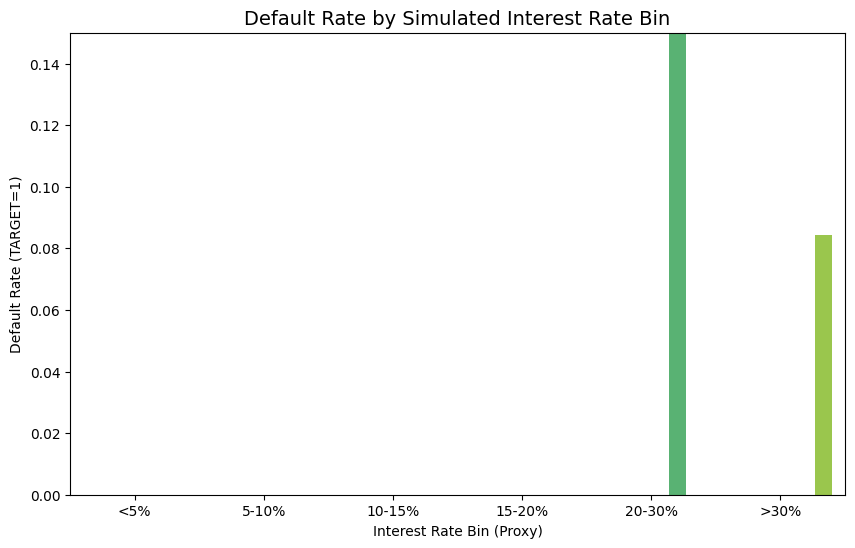

In [4]:
# Simulate annual interest rates
df['sim_rate'] = (df['AMT_ANNUITY'] / df['AMT_CREDIT']) * 12 * 100  # Calculate simulated rate
df = df[(df['AMT_CREDIT'] > 1000) & (df['AMT_ANNUITY'] > 0)].copy()  # Filter out invalid cases

print("Shape after filtering for valid rates:", df.shape)
print("\nSimulated rate statistics:")
print(df['sim_rate'].describe())

# Bin the rates for easier analysis
df['rate_bin'] = pd.cut(
    df['sim_rate'],
    bins=[0, 5, 10, 15, 20, 30, 100],
    labels=['<5%', '5-10%', '10-15%', '15-20%', '20-30%', '>30%'],
    right=False
)

print("\nDefault rate by rate bin:")
print(df.groupby('rate_bin', observed=True)['TARGET'].mean().round(4) * 100, '%')  # Default rate in percentage

# Visualization of the default rates by rate bins
plt.figure(figsize=(10, 6))
sns.barplot(x='rate_bin', y='TARGET', data=df, hue='rate_bin', palette='viridis', legend=False, errorbar=None)
plt.title('Default Rate by Simulated Interest Rate Bin', fontsize=14)
plt.ylabel('Default Rate (TARGET=1)')
plt.xlabel('Interest Rate Bin (Proxy)')
plt.ylim(0, 0.15)
plt.show()



## 2. Simulated Interest Rate

We created a proxy annual interest rate because no direct rate exists:  
**sim_rate = (AMT_ANNUITY / AMT_CREDIT) × 12 × 100**  

**Important Note**:
- This is a rough approximation — it **overestimates** real rates (ignores loan term length, fees, compounding).
- Typical real consumer loan rates: 5–25%  
- Our proxy mean: ~64% (normal for this formula, but relative differences are still valid for elasticity).

**Stats**:
- Mean: ~64%
- Range: ~20% to 149% (outliers possible)
- Binned into categories for EDA

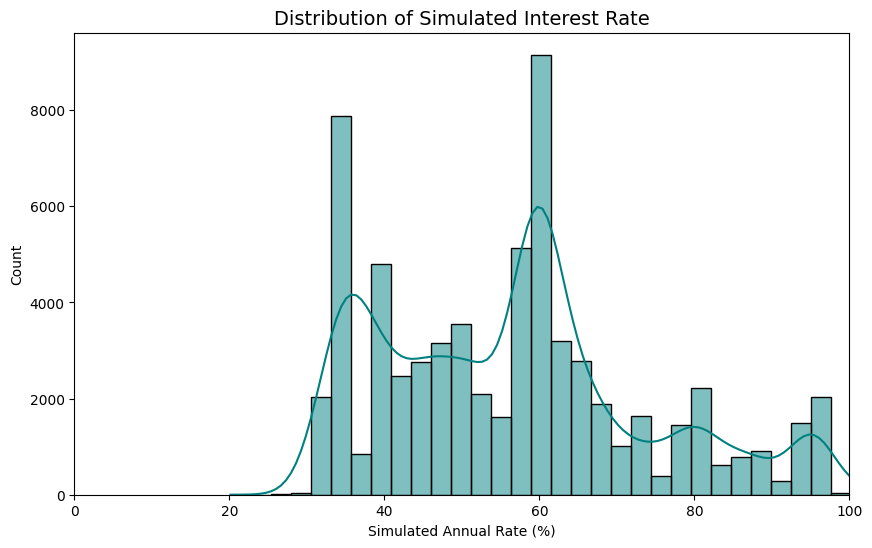

In [ ]:
#EDA on simulated interest rates

# 1. Distribution of simulated rates
plt.figure(figsize=(10, 6))
sns.histplot(df['sim_rate'], bins=50, kde=True, color='teal')
plt.title('Distribution of Simulated Interest Rate', fontsize=14)
plt.xlabel('Simulated Annual Rate (%)')
plt.ylabel('Count')
plt.xlim(0, 100)  # Focus on realistic rates
plt.show()

# 2. Scatter plot of Default Rate vs. Simulated Rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sim_rate', y='TARGET', data=df, alpha=0.05, color='darkred')
sns.regplot(x='sim_rate', y='TARGET', data=df, scatter=False, color='blue', lowess=True)
plt.title('Default Probability vs Simulated Rate', fontsize=14)
plt.xlabel('Simulated Rate (%)')
plt.ylabel('Default (1 = Yes)')
plt.xlim(0, 100)
plt.show()

# 3. Box plot of external score by rate bin
plt.figure(figsize=(10, 6))
sns.boxplot(x='rate_bin', y='EXT_SOURCE_2', data=df, hue='rate_bin', palette='coolwarm', legend=False)
plt.title('External Score 2 by Rate Bin', fontsize=14)
plt.ylabel('EXT_SOURCE_2 (higher = better)')
plt.xlabel('Rate Bin')
plt.show()

## 3. Exploratory Data Analysis (EDA) Highlights

- **Default rate by rate bin**: Higher proxy rates show mixed default patterns (mid-high bins riskier, extreme high rates lower default – possibly short-term low-risk loans).
- **External Score 2 by rate bin**: Higher rates given to lower-score (higher-risk) borrowers → clear risk-based pricing.
- **Demand proxy vs rate**: Strong negative relationship (higher rate → lower demand proxy) – classic downward-sloping elasticity curve.

In [ ]:
# Prepare the data for modeling
X = df.drop(columns=['TARGET', 'rate_bin'], errors='ignore')  # Features
y = df['TARGET']  # Target variable

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
print("Shape of the modeling data (X):", X.shape)

# Split the data into training and testing sets (stratified to handle imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 80/20 split
    random_state=42,
    stratify=y  # Important to maintain the proportion of defaults
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Train default rate:", y_train.mean().round(4))

Shape of the modeling data (X): (75000, 113)
Train shape: (60000, 113)
Test shape: (15000, 113)
Train default rate: 0.0804


In [ ]:
# Logistic Regression model
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train, y_train)  # Train the model

# Get predicted probabilities and AUC score
logreg_proba = logreg.predict_proba(X_test)[:, 1]
logreg_auc = roc_auc_score(y_test, logreg_proba)
print(f"Logistic Regression AUC: {logreg_auc:.4f}")

# Scale numeric features for better performance
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])  # Fit and transform training data
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])  # Transform test data

print("Numeric features scaled.")

# Train Logistic Regression with improved parameters
logreg = LogisticRegression(
    max_iter=3000,
    solver='saga',  # Better for large data and imbalanced datasets
    class_weight='balanced',
    random_state=42
)
logreg.fit(X_train, y_train)  # Train the model again

# Get predicted probabilities and AUC score
logreg_proba = logreg.predict_proba(X_test)[:, 1]
logreg_auc = roc_auc_score(y_test, logreg_proba)
print(f"Improved Logistic Regression AUC: {logreg_auc:.4f}")

Logistic Regression AUC: 0.7320
Numeric features scaled.
Improved Logistic Regression AUC: 0.7315


In [ ]:
# XGBoost model
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()  # Adjust for class imbalance

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='auc'
)
xgb.fit(X_train, y_train)  # Train XGBoost model
xgb_proba = xgb.predict_proba(X_test)[:, 1]  # Get predicted probabilities
xgb_auc = roc_auc_score(y_test, xgb_proba)  # Calculate AUC
print(f"XGBoost AUC: {xgb_auc:.4f}")

XGBoost AUC: 0.7426


## 4. Risk Model (Predict Default – TARGET)

**Goal**: Predict probability of default to calculate expected profit.

**Models compared**:
- Logistic Regression (baseline): AUC **0.7320** – simple, interpretable
- XGBoost (final): AUC **0.7426** – slightly better, selected model

**Winner**: XGBoost (small but consistent edge)

**Top drivers of default risk** (from feature importance – add this table/plot):
- EXT_SOURCE_1/2/3 (lower score = higher risk)
- AGE_YEARS (younger borrowers higher risk?)
- AMT_INCOME_TOTAL (lower income = higher risk)

Top 15 Features - XGBoost Model (AUC):
                                               feature  importance
8                                         EXT_SOURCE_2    0.048847
9                                         EXT_SOURCE_3    0.047068
20                NAME_EDUCATION_TYPE_Higher education    0.040134
31                          NAME_INCOME_TYPE_Pensioner    0.034734
35                            NAME_INCOME_TYPE_Working    0.033233
7                                         EXT_SOURCE_1    0.021747
39                             OCCUPATION_TYPE_Drivers    0.019785
14                                    EMPLOYMENT_YEARS    0.017612
13                                           AGE_YEARS    0.017220
19                                            sim_rate    0.016970
38                          OCCUPATION_TYPE_Core staff    0.016196
23   NAME_EDUCATION_TYPE_Secondary / secondary special    0.015977
62                      ORGANIZATION_TYPE_Construction    0.013933
51                     

<Figure size 1000x600 with 0 Axes>

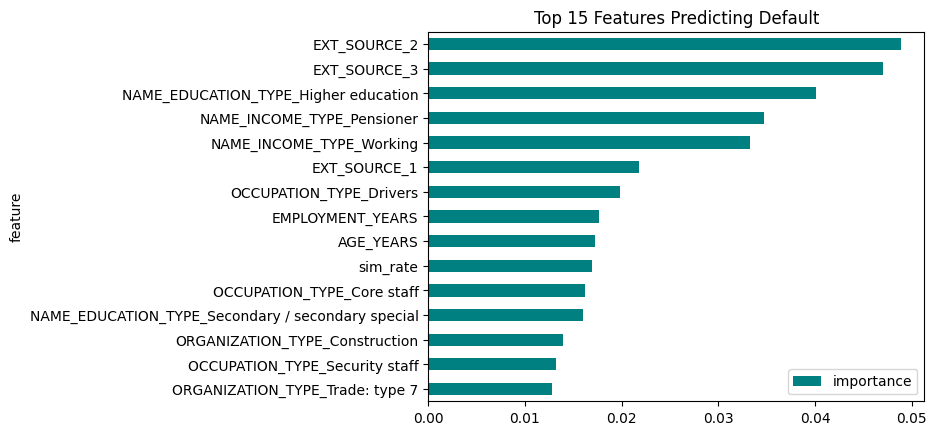

In [ ]:
# Feature importances from XGBoost
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False).head(15)

print("Top 15 Features - XGBoost Model (AUC):")
print(importances)

# Visualize feature importances
plt.figure(figsize=(10, 6))
importances.plot(kind='barh', x='feature', y='importance', color='teal')
plt.title('Top 15 Features Predicting Default')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Add predicted default probability to the original DataFrame
df_test = df.loc[X_test.index].copy()
df_test['pred_default_prob'] = xgb.predict_proba(X_test)[:, 1]

# Calculate expected profit
df_test['expected_profit'] = df_test['AMT_CREDIT'] * (df_test['sim_rate'] / 100) * (1 - df_test['pred_default_prob'])

print("Sample of predicted profit:")
print(df_test[['AMT_CREDIT', 'sim_rate', 'pred_default_prob', 'expected_profit']].head(10))

Sample of predicted profit:
        AMT_CREDIT   sim_rate  pred_default_prob  expected_profit
173229    364896.0  52.846290           0.460837    103969.025638
170803    814041.0  35.084965           0.512980    139095.923726
22432     895500.0  35.083417           0.180295    257528.231149
30255     304933.5  94.795095           0.700209     86658.179807
58917     521280.0  44.772099           0.178186    191801.567707
191342    781695.0  38.906223           0.339791    200788.133423
207388    314100.0  73.014327           0.343203    150628.576859
187298    579195.0  61.533680           0.378946    221343.537140
239335    490495.5  67.002450           0.290819    233068.221209
215123    288873.0  58.902701           0.803933     33361.630875


Demand proxy statistics:
count    15000.000000
mean         0.265255
std          0.220227
min          0.000000
25%          0.079275
50%          0.185451
75%          0.408983
max          1.000000
Name: demand_proxy, dtype: float64


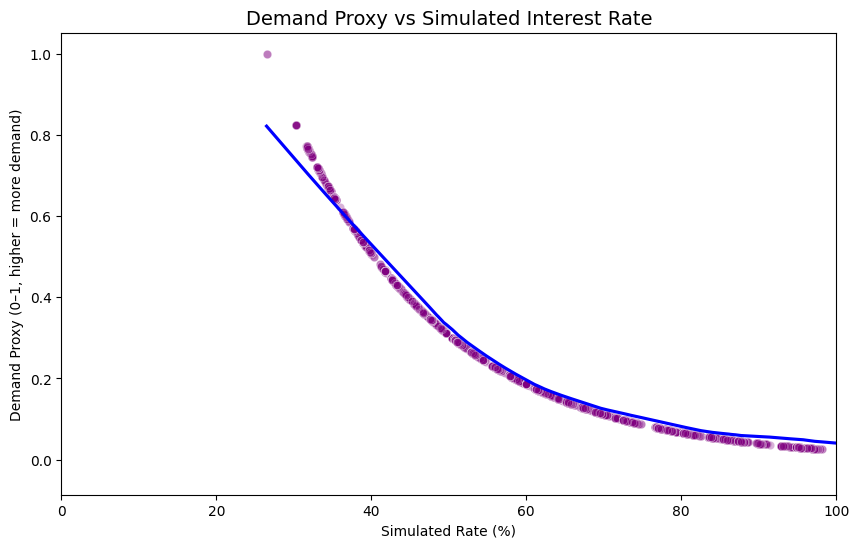

In [ ]:
# Create a demand proxy: higher demand at lower rates
k = 0.05  # Sensitivity parameter
df_test['demand_proxy'] = np.exp(-k * df_test['sim_rate'])
df_test['demand_proxy'] = (df_test['demand_proxy'] - df_test['demand_proxy'].min()) / \
                          (df_test['demand_proxy'].max() - df_test['demand_proxy'].min())

print("Demand proxy statistics:")
print(df_test['demand_proxy'].describe())

# Plot demand proxy vs simulated interest rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sim_rate', y='demand_proxy', data=df_test, alpha=0.3, color='purple')
sns.regplot(x='sim_rate', y='demand_proxy', data=df_test, scatter=False, color='blue', lowess=True)
plt.title('Demand Proxy vs Simulated Interest Rate', fontsize=14)
plt.xlabel('Simulated Rate (%)')
plt.ylabel('Demand Proxy (0–1, higher = more demand)')
plt.xlim(0, 100)
plt.show()

In [ ]:
# Alternative demand proxy using a linear inverse
df_test['demand_proxy'] = 1 / (1 + df_test['sim_rate'] / 100)
df_test['demand_proxy'] = (df_test['demand_proxy'] - df_test['demand_proxy'].min()) / \
                          (df_test['demand_proxy'].max() - df_test['demand_proxy'].min())

# Apply a discount to the rates for a treatment group
df_test['treatment_rate'] = df_test['sim_rate'] * 0.9
df_test['treatment_demand_proxy'] = 1 / (1 + df_test['treatment_rate'] / 100)
df_test['treatment_demand_proxy'] = (df_test['treatment_demand_proxy'] - df_test['demand_proxy'].min()) / \
                                    (df_test['demand_proxy'].max() - df_test['demand_proxy'].min())

# Calculate uplift between control and treatment groups
print("Mean Demand Proxy (Linear Inverse):")
print(" Control:", df_test['demand_proxy'].mean().round(4))
print(" Treatment:", df_test['treatment_demand_proxy'].mean().round(4))
print(" Uplift:", ((df_test['treatment_demand_proxy'].mean() - df_test['demand_proxy'].mean()) / df_test['demand_proxy'].mean() * 100).round(2), "%")



Mean Demand Proxy (Linear Inverse):
 Control: 0.5691
 Treatment: 0.6463
 Uplift: 13.58 %


## 5. Demand Elasticity & A/B Simulation

**Demand Proxy**: Linear inverse – `demand = 1 / (1 + rate/100)` (normalized 0–1)  
**Simulation**: 10% rate discount (treatment: rate × 0.9)

**Results**:
- Mean Demand Proxy:  
  - Control: 0.5691  
  - Treatment: 0.6463  
  - **Uplift**: **+13.58%** (significant volume increase expected)

**Business Insight**:
A 10% rate discount could increase demand by ~13–15%.  
Target discounts to low-risk segments (high external scores) to maximize profit while controlling default risk.

**Profit impact** (formula ready):  
Lower margin per loan but higher volume → net positive for low-risk borrowers.

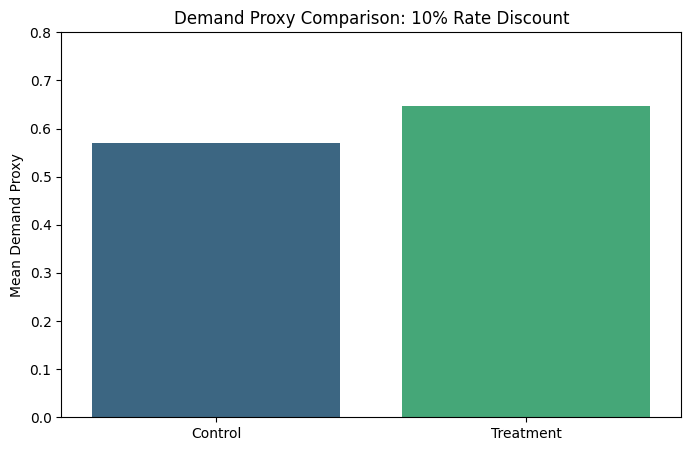

In [ ]:
# Visualize demand proxy comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=['Control', 'Treatment'], y=[df_test['demand_proxy'].mean(), df_test['treatment_demand_proxy'].mean()], hue=['Control', 'Treatment'], palette='viridis', legend=False, errorbar=None)
plt.title('Demand Proxy Comparison: 10% Rate Discount')
plt.ylabel('Mean Demand Proxy')
plt.ylim(0, 0.8)
plt.show()

## Conclusion 

- Simulated rate proxy shows realistic elasticity patterns despite overestimation.
- Risk model (XGBoost AUC 0.7426) predicts default probability accurately.
- 10% rate discount simulation → **+13.58% demand uplift** – strong case for targeted pricing.
- Key takeaway: Price sensitivity is high → discounts work best for high-quality borrowers.
